In [1]:
import numpy
import h5py
import time
import os, sys
import random
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
import argparse

In [7]:
from sklearn.model_selection import train_test_split

In [2]:
### ONLY RUN ON PRE-TRANSFORMED FILES!!!!!!!!!! ###
## RUN TrasnformFiles_OutputHDF5 first ### 
### Import Files ###
#input_file = 'Level5_IC86.2013_genie_numu.014640.100.transformed_zenith.hdf5'
file_dir = '/mnt/scratch/micall12/training_files/'
input_file = file_dir + 'Level5_IC86.2013_genie_nue.012640.100.cascade.lt60_vertexDC.transformed.hdf5'
filename = "100_TEST"
save = False
save_folder_name = "CNN_test_files_%s/"%(filename)

f = h5py.File(input_file, 'r')
Y_train = f['Y_train'][:]
Y_test = f['Y_test'][:]
X_train_DC = f['X_train_DC'][:]
X_test_DC = f['X_test_DC'][:]
X_train_IC = f['X_train_IC'][:]
X_test_IC = f['X_test_IC'][:]
f.close()
del f

Y_train = Y_train[:,0] # ENERGY ONLY
#Y_test = Y_test[:,0] # ENERGY ONLY

# Return features and labels, to be used for network
num_features_DC = X_train_DC.shape[-1]
num_features_IC = X_train_IC.shape[-1]
num_labels = 1 #Y_train.shape[-1] ## NEED TO CHANGE MANUALLY!
print("Training set: %i, Testing set: %i"%(len(Y_train),len(Y_test)))

Training set: 119676, Testing set: 13298


In [4]:
### Build The Network ##

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import initializers
from keras.optimizers import SGD
from keras.optimizers import Adam

## MIRCO NETWORK ##

# DEEP CORE #
print("Train Data DC", X_train_DC.shape)
strings = X_train_DC.shape[1]
dom_per_string = X_train_DC.shape[2]
dom_variables = X_train_DC.shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
DC_drop_value = 0.2
input_DC = Input(shape=(strings, dom_per_string, dom_variables))

conv1_DC = Conv2D(100,kernel_size=(strings,5),padding='same',activation='tanh')(input_DC) #tanh
#z1 = keras.layers.BatchNormalization()(z1)
pool1_DC = MaxPooling2D(pool_size=(1,2))(conv1_DC)
drop1_DC = Dropout(DC_drop_value)(pool1_DC)

conv2_DC = Conv2D(100,kernel_size=(strings,7),padding='same',activation='relu')(drop1_DC) #relu
drop2_DC = Dropout(DC_drop_value)(conv2_DC)

conv3_DC = Conv2D(100,kernel_size=(strings,7),padding='same',activation='relu')(drop2_DC)
drop3_DC = Dropout(DC_drop_value)(conv3_DC)

conv4_DC = Conv2D(100,kernel_size=(strings,3),padding='valid',activation='relu')(drop3_DC)
pool4_DC = MaxPooling2D(pool_size=(1,2))(conv4_DC)
drop4_DC = Dropout(DC_drop_value)(pool4_DC)

conv5_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop4_DC)
drop5_DC = Dropout(DC_drop_value)(conv5_DC)

conv6_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop5_DC)
drop6_DC = Dropout(DC_drop_value)(conv6_DC)

conv7_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop6_DC)
drop7_DC = Dropout(DC_drop_value)(conv7_DC)

conv8_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop7_DC)
drop8_DC = Dropout(DC_drop_value)(conv8_DC)

flat_DC = Flatten()(drop8_DC)


# ICECUBE NEAR DEEPCORE #
print("Train Data IC", X_train_IC.shape)
strings_IC = X_train_IC.shape[1]
dom_per_string_IC = X_train_IC.shape[2]
dom_variables_IC = X_train_IC.shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
IC_drop_value = 0.2
input_IC = Input(shape=(strings_IC, dom_per_string_IC, dom_variables_IC))

conv1_IC = Conv2D(100,kernel_size=(strings_IC,5),padding='same',activation='tanh')(input_IC)
pool1_IC = MaxPooling2D(pool_size=(1,2))(conv1_IC)
drop1_IC = Dropout(IC_drop_value)(pool1_IC)

conv2_IC = Conv2D(100,kernel_size=(strings_IC,7),padding='same',activation='relu')(drop1_IC)
drop2_IC = Dropout(IC_drop_value)(conv2_IC)

conv3_IC = Conv2D(100,kernel_size=(strings_IC,7),padding='same',activation='relu')(drop2_IC)
drop3_IC = Dropout(IC_drop_value)(conv3_IC)

conv4_IC = Conv2D(100,kernel_size=(strings_IC,3),padding='valid',activation='relu')(drop3_IC)
pool4_IC = MaxPooling2D(pool_size=(1,2))(conv4_IC)
drop4_IC = Dropout(IC_drop_value)(pool4_IC)

conv5_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop4_IC)
drop5_IC = Dropout(IC_drop_value)(conv5_IC)

conv6_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop5_IC)
drop6_IC = Dropout(IC_drop_value)(conv6_IC)

conv7_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop6_IC)
drop7_IC = Dropout(IC_drop_value)(conv7_IC)

conv8_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop7_IC)
drop8_IC = Dropout(IC_drop_value)(conv8_IC)

flat_IC = Flatten()(drop8_IC)


# PUT TOGETHER #
connected_drop_value = 0.2
concatted = concatenate([flat_DC, flat_IC])

full1 = Dense(300,activation='relu')(concatted)
dropf = Dropout(connected_drop_value)(full1)

output = Dense(num_labels,activation='linear')(dropf)
#lambda_layer = Lambda(lambda x: (x*20.)/1.+3)(output)
lambda_layer = Lambda(lambda x: (x*355)/1.)(output)
model_DC = Model(inputs=[input_DC,input_IC],outputs=lambda_layer)

#print(model_DC.summary())

('Train Data DC', (119676, 8, 60, 5))
('Train Data IC', (119676, 7, 60, 5))


In [5]:
## Compile ##
model_DC.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.000001), #0.00001
              metrics=['mean_squared_error'])


In [ ]:
## Run neural network and record time ##
t0 = time.time()
network_history = model_DC.fit([X_train_DC, X_train_IC], Y_train,
                            batch_size=256,
                            validation_split=0.25,
                            epochs=5,
                            verbose=1)

t1 = time.time()
print("This took me %f minutes"%((t1-t0)/60.))

Train on 89757 samples, validate on 29919 samples
Epoch 1/5
44288/89757 [=============>................] - ETA: 6:06 - loss: 1375.3179 - mean_squared_error: 1375.3179

In [46]:
score = model_DC.evaluate([X_test_DC,X_test_IC], Y_test[:,0], batch_size=256)
print("final score on test data: loss: {:.4f} / accuracy: {:.4f}".format(score[0], score[1]))
print(network_history.history.keys())
print(score)

13298/13298 [==============================] - 2s 181us/step
final score on test data: loss: 74.7990 / accuracy: 74.7990
dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])
[74.7989980198778, 74.798998182815694]


In [47]:
def plot_history(network_history,save=False,savefolder=None):
    """
    Plot history of neural network's loss vs. epoch
    Recieves:
        network_history = array, saved metrics from neural network training
        save = optional, bool to save plot
        savefolder = optional, output folder to save to, if not in current dir
    Returns:
        one plot, saved to files
    """
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.yscale('log')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    if save == True:
        plt.savefig("%sloss_vs_epochs.png"%savefolder)

In [48]:
#ENERGY
def plot_prediction(Y_test, Y_test_predicted,save=False,savefolder=None):
    """
    Plot testing set prediction vs truth and fractional error
    Recieves:
        Y_test = array, Y_test truth
        Y_test_prediction = array, neural network prediction output
        save = optional, bool to save plot
        savefolder = optional, output folder to save to, if not in current dir
    Returns:
        two plots, saved to files
    """
    plt.figure()
    cts,xbin,ybin,img = plt.hist2d(Y_test, Y_test_predicted, bins=60,)
    plt.plot([0,60],[0,60],'k:')
    plt.xlim(0,60)
    plt.ylim(0,60)
    plt.xlabel("True Energy")
    plt.ylabel("NN Predicted Energy")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('counts', rotation=90)
    plt.set_cmap('viridis_r')
    plt.title("Prediction (from NN) vs Truth for Energy")
    if save == True:
        plt.savefig("%senergy_prediction_truth.png"%savefolder)

    fractional_error = abs(Y_test - Y_test_predicted)/ Y_test
    plt.figure()
    plt.title("Fractional Error vs. Energy")
    plt.hist2d(Y_test, fractional_error,bins=60);
    plt.xlabel("True Energy")
    plt.ylabel("Fractional Error")
    #plt.ylim(0,0.5)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('counts', rotation=90)
    if save == True:
        plt.savefig("%sFractionalError.png"%savefolder)


In [51]:
#Use test set to predict values
Y_test_predicted = model_DC.predict([X_test_DC,X_test_IC])

Y_test_all_labels = numpy.copy(Y_test)
Y_test_predicted = numpy.reshape(Y_test_predicted, Y_test_predicted.shape[0])
Y_test = numpy.reshape(Y_test[:,0], Y_test.shape[0])

if save==True:
    if os.path.isdir(save_folder_name) != True:
        os.mkdir(save_folder_name)
    file = open("%soutput.txt"%save_folder_name,"w")
    file.write("training on {} samples, testing on {} samples".format(num_train, len(features)-num_train))
    file.write("final score on test data: loss: {:.4f} / accuracy: {:.4f}\n".format(score[0], score[1]))
    file.write("This took %f minutes"%((t1-t0)/60.))
    file.close()

In [2]:
def plot_distribution(Y_test,Y_test_prediction,all_Y_test_labels):
    CC_mask = Y_test_all_labels[:,11] ==1
    NC_mask = Y_test_all_labels[:,11] ==0

    plt.figure()
    plt.title("True Energy Distribution")
    plt.hist(Y_test[CC_mask], bins=100,color='b',alpha=0.5,label="CC");
    plt.hist(Y_test[NC_mask], bins=100,color='g',alpha=0.5,label="NC");
    plt.legend()

    plt.figure()
    plt.title("NN Energy Distribution")
    plt.hist(Y_test_predicted[CC_mask], bins=100,color='b', alpha=0.5, label="CC");
    plt.hist(Y_test_predicted[NC_mask], bins=100,color='g', alpha=0.5, label="NC");
    plt.legend()

def plot_resolution(Y_test,Y_test_prediction,all_Y_test_labels):
    CC_mask = Y_test_all_labels[:,11] ==1
    NC_mask = Y_test_all_labels[:,11] ==0
    
    resolution = Y_test_predicted - Y_test
    resolution_fraction = (Y_test_predicted- Y_test)/Y_test

    plt.figure()  
    plt.title("Energy Resolution")
    plt.hist(resolution[CC_mask], bins=50,color='b', alpha=0.5, label="CC");
    plt.hist(resolution[NC_mask], bins=50,color='g', alpha=0.5, label="NC");
    plt.xlabel("NN prediction - truth (GeV)")
    plt.legend()

    plt.figure()  
    plt.title("Fractional Energy Resolution")
    plt.hist(resolution_fraction[CC_mask], bins=50,color='b', alpha=0.5, label="CC");
    plt.hist(resolution_fraction[NC_mask], bins=50,color='g', alpha=0.5, label="NC");
    plt.xlabel("(NN prediction - truth) / truth")
    plt.legend()

In [3]:
plot_distribution(Y_test,Y_test_prediction,all_Y_test_labels)
plot_resolution(Y_test,Y_test_prediction,all_Y_test_labels)

NameError: name 'Y_test' is not defined

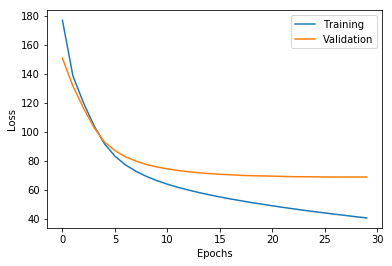

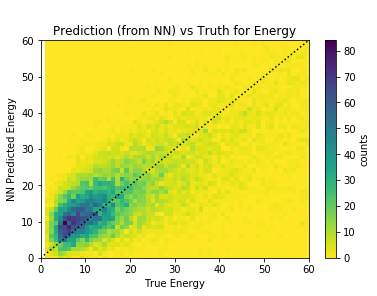

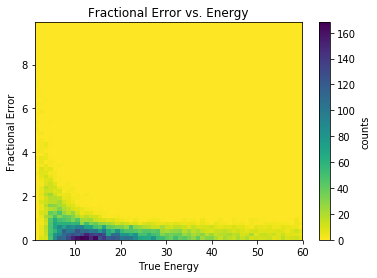

In [54]:
plot_history(network_history,save,save_folder_name)
plot_prediction(Y_test, Y_test_predicted,save,save_folder_name)

In [55]:
plt.figure()
cts,xbin,ybin,img = plt.hist2d(Y_test[CC_mask], Y_test_predicted[CC_mask], bins=60,)
plt.plot([0,60],[0,60],'k:')
plt.xlim(0,60)
plt.ylim(0,60)
plt.xlabel("True Energy")
plt.ylabel("NN Predicted Energy")
cbar = plt.colorbar()
cbar.ax.set_ylabel('counts', rotation=90)
plt.set_cmap('viridis_r')
plt.title("Prediction (from NN) vs Truth for Energy - CC ONLY")

NameError: name 'mask_CC' is not defined

In [56]:
plt.figure()
cts,xbin,ybin,img = plt.hist2d(Y_test[NC_mask], Y_test_predicted[NC_mask], bins=60,)
plt.plot([0,60],[0,60],'k:')
plt.xlim(0,60)
plt.ylim(0,60)
plt.xlabel("True Energy")
plt.ylabel("NN Predicted Energy")
cbar = plt.colorbar()
cbar.ax.set_ylabel('counts', rotation=90)
plt.set_cmap('viridis_r')
plt.title("Prediction (from NN) vs Truth for Energy - NC ONLY")

NameError: name 'mask_NC' is not defined